In [2]:
import ltn
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Nodes information
raw_nodes = {
    "Hannover": (9.80, 52.39),
    "Frankfurt": (8.66, 50.14),
    "Hamburg": (10.08, 53.55),
    "Norden": (7.21, 53.60),
    "Bremen": (8.80, 53.08),
    "Berlin": (13.48, 52.52),
    "Muenchen": (11.55, 48.15),
    "Ulm": (9.99, 48.40),
    "Nuernberg": (11.08, 49.45),
    "Stuttgart": (9.12, 48.73),
    "Karlsruhe": (8.41, 49.01),
    "Mannheim": (8.49, 49.49),
    "Essen": (7.00, 51.44),
    "Dortmund": (7.48, 51.51),
    "Duesseldorf": (6.78, 51.22),
    "Koeln": (7.01, 50.92),
    "Leipzig": (12.38, 51.34)
}
# Convert raw_nodes to LTN constants
embedding_size = 2
# nodes = {k: ltn.Constant(torch.rand((embedding_size,)), trainable=True) for k, v in raw_nodes.items()}
nodes = {k: ltn.Constant(torch.tensor(v, device=device)) for k, v in raw_nodes.items()}


# Links information
raw_links = {
    "L1": ("Berlin", "Hamburg"),
    "L2": ("Berlin", "Hannover"),
    "L3": ("Berlin", "Leipzig"),
    "L4": ("Bremen", "Hamburg"),
    "L5": ("Bremen", "Hannover"),
    "L6": ("Bremen", "Norden"),
    "L7": ("Dortmund", "Essen"),
    "L8": ("Dortmund", "Hannover"),
    "L9": ("Dortmund", "Koeln"),
    "L10": ("Dortmund", "Norden"),
    "L11": ("Duesseldorf", "Essen"),
    "L12": ("Duesseldorf", "Koeln"),
    "L13": ("Frankfurt", "Hannover"),
    "L14": ("Frankfurt", "Koeln"),
    "L15": ("Frankfurt", "Leipzig"),
    "L16": ("Frankfurt", "Mannheim"),
    "L17": ("Frankfurt", "Nuernberg"),
    "L18": ("Hamburg", "Hannover"),
    "L19": ("Hannover", "Leipzig"),
    "L20": ("Karlsruhe", "Mannheim"),
    "L21": ("Karlsruhe", "Stuttgart"),
    "L22": ("Leipzig", "Nuernberg"),
    "L23": ("Muenchen", "Nuernberg"),
    "L24": ("Muenchen", "Ulm"),
    "L25": ("Nuernberg", "Stuttgart"),
    "L26": ("Stuttgart", "Ulm")
}
# define the link relation
links = list(raw_links.values())
# down link is L1, and initialize the down_link as a ltn constant
down_link = ("Berlin", "Hamburg")
print(f"down_link: {down_link}")

# because the down_link(source, target) - > affected_nodes(source) and affected_nodes(target)
affected_nodes = [down_link[0], down_link[1]]
affected_links = [down_link, (down_link[0], 'Hannover'), (down_link[0], 'Leipzig'), (down_link[1], 'Hannover'), (down_link[1], 'Bremen')]
print(f"affected_nodes: {affected_nodes}")
print(f"affected_links: {affected_links}")

healthy_nodes = [k for k in nodes.keys() if k not in affected_nodes]
healthy_links = [k for k in links if k not in affected_links]
print(f"healthy_nodes: {healthy_nodes}")
print(f"healthy_links: {healthy_links}")

down_link: ('Berlin', 'Hamburg')
affected_nodes: ['Berlin', 'Hamburg']
affected_links: [('Berlin', 'Hamburg'), ('Berlin', 'Hannover'), ('Berlin', 'Leipzig'), ('Hamburg', 'Hannover'), ('Hamburg', 'Bremen')]
healthy_nodes: ['Hannover', 'Frankfurt', 'Norden', 'Bremen', 'Muenchen', 'Ulm', 'Nuernberg', 'Stuttgart', 'Karlsruhe', 'Mannheim', 'Essen', 'Dortmund', 'Duesseldorf', 'Koeln', 'Leipzig']
healthy_links: [('Bremen', 'Hamburg'), ('Bremen', 'Hannover'), ('Bremen', 'Norden'), ('Dortmund', 'Essen'), ('Dortmund', 'Hannover'), ('Dortmund', 'Koeln'), ('Dortmund', 'Norden'), ('Duesseldorf', 'Essen'), ('Duesseldorf', 'Koeln'), ('Frankfurt', 'Hannover'), ('Frankfurt', 'Koeln'), ('Frankfurt', 'Leipzig'), ('Frankfurt', 'Mannheim'), ('Frankfurt', 'Nuernberg'), ('Hannover', 'Leipzig'), ('Karlsruhe', 'Mannheim'), ('Karlsruhe', 'Stuttgart'), ('Leipzig', 'Nuernberg'), ('Muenchen', 'Nuernberg'), ('Muenchen', 'Ulm'), ('Nuernberg', 'Stuttgart'), ('Stuttgart', 'Ulm')]


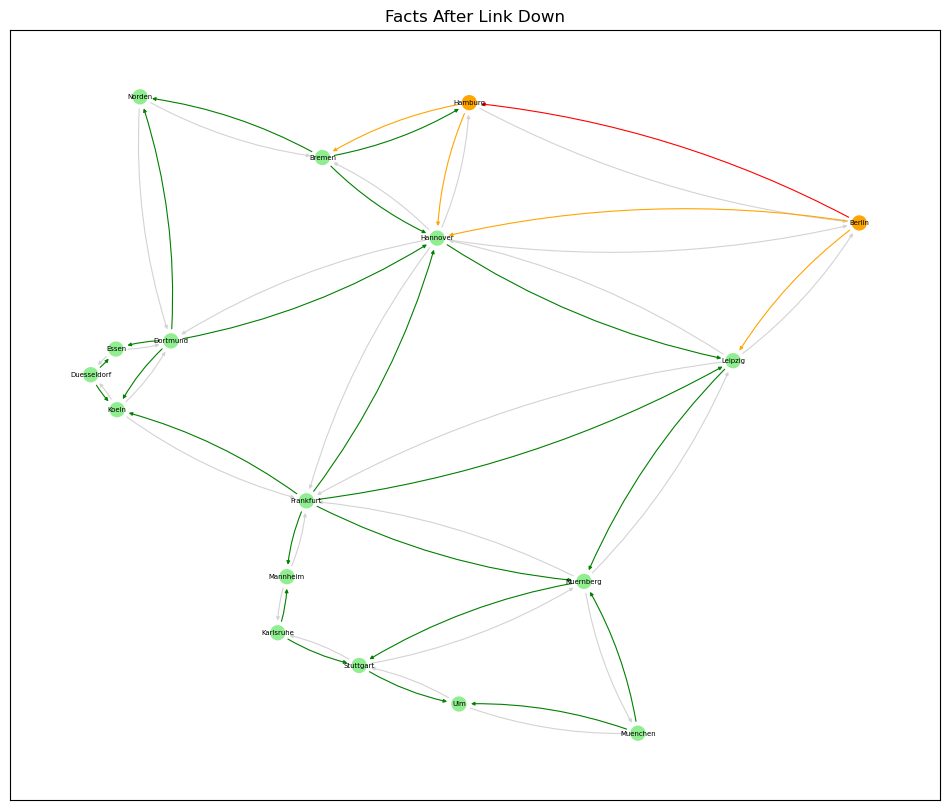

In [3]:
# Illustrate the facts of nodes/affected_nodes and links/affected_links
'''
plot the bidirected graph, for the link not in links, the color is grey
for the link in affected_links, the color is orange
for the link in healthy_links, the color is green
for the node in affected_nodes, the color is orange
for the node in healthy_nodes, the color is green
'''
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(nodes.keys())
for source, target in links:
    G.add_edge(source, target)  # original edge
    G.add_edge(target, source)  # reverse edge
pos = {k: v for k, v in raw_nodes.items()}
# Define node colors
node_colors = ['orange' if node in affected_nodes else 'lightgreen' for node in G.nodes()]
# Define edge colors
edge_colors = []
for edge in G.edges():
    if edge in links:  # original direction
        if edge == down_link:
            edge_colors.append('red')
        elif edge in affected_links:
            edge_colors.append('orange')
        else:
            edge_colors.append('green')
    else:  # reverse direction
        if edge in affected_links:
            edge_colors.append('orange')
        else:
            edge_colors.append('lightgrey')

# Create the plot with adjusted parameters
plt.figure(figsize=(12, 10))  # Adjust figure size
nx.draw_networkx_nodes(G, pos,
                      node_size=100,
                      node_color=node_colors)

nx.draw_networkx_labels(G, pos,
                       font_size=5)
# Draw edges with curved arrows
curved_edges = [(u, v) for (u, v) in G.edges()]
nx.draw_networkx_edges(G, pos,
                      edgelist=curved_edges,
                      edge_color=edge_colors,
                      connectionstyle='arc3,rad=0.1',
                      arrowsize=5,
                      width=0.8)
plt.title("Facts After Link Down")
plt.show()

In [4]:
class MLP(torch.nn.Module):
    """
    Simple MLP model used for defining the predicates of our problem.
    """
    def __init__(self, layer_sizes=(10, 16, 16, 1)):
        super(MLP, self).__init__()
        self.elu = torch.nn.ELU()
        self.sigmoid = torch.nn.Sigmoid()
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i])
                                                  for i in range(1, len(layer_sizes))])
        self.to(device)

    def forward(self, *x):
        """
        Given an individual x, the forward phase of this MLP returns the probability that the individual x is a smoker,
        or has cancer, or is friend of y (if given and predicate is F).

        :param x: individuals for which we have to compute the probability
        :return: the probability that individual x is a smoker, or has cancer, or is friend of y (if given)
        """
        x = list(x)
        if len(x) == 1:
            x = x[0]
        else:
            x = torch.cat(x, dim=1)
        x = x.to(device)
        for layer in self.linear_layers[:-1]:
            x = self.elu(layer(x))
        out = self.sigmoid(self.linear_layers[-1](x))
        return out

Link = ltn.Predicate(MLP(layer_sizes=(4, 32, 32, 1)))
Node = ltn.Predicate(MLP(layer_sizes=(2, 32, 32, 1)))

# define connectives, quantifiers, and SatAgg
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

In [12]:
# nodes = {k: ltn.Constant(torch.tensor(v, device=device)) for k, v in raw_nodes.items()}
bad_nodes = ['Berlin', 'Hamburg']
all_nodes = list(nodes.keys())

bad_links = [('Berlin', 'Hamburg'), ('Berlin', 'Hannover'), ('Berlin', 'Leipzig'), ('Hamburg', 'Hannover'), ('Hamburg', 'Bremen')]
all_links = list(raw_links.values())

n_ = ltn.Variable("n", torch.stack([i.value for i in nodes.values()]))
m_ = ltn.Variable("m", torch.stack([i.value for i in nodes.values()]))

In [18]:
class MLP(torch.nn.Module):
    """
    Simple MLP model used for defining the predicates of our problem.
    """
    def __init__(self, layer_sizes=(10, 16, 16, 1)):
        super(MLP, self).__init__()
        self.elu = torch.nn.ELU()
        self.sigmoid = torch.nn.Sigmoid()
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i])
                                                  for i in range(1, len(layer_sizes))])
        self.to(device)

    def forward(self, *x):
        """
        Given an individual x, the forward phase of this MLP returns the probability that the individual x is a smoker,
        or has cancer, or is friend of y (if given and predicate is F).

        :param x: individuals for which we have to compute the probability
        :return: the probability that individual x is a smoker, or has cancer, or is friend of y (if given)
        """
        x = list(x)
        if len(x) == 1:
            x = x[0]
        else:
            x = torch.cat(x, dim=1)
        x = x.to(device)
        for layer in self.linear_layers[:-1]:
            x = self.elu(layer(x))
        out = self.sigmoid(self.linear_layers[-1](x))
        return out

Link = ltn.Predicate(MLP(layer_sizes=(4, 32, 32, 1)))
Node = ltn.Predicate(MLP(layer_sizes=(2, 32, 32, 1)))

# define connectives, quantifiers, and SatAgg
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

def phi_1(n_):    # false
    return Exists(n_, Link(n_, n_), p = 2).value

def phi_2(bad_links, all_links):    # true
    good_links = [(s, t) for (s, t) in all_links if (s, t) not in bad_links]
    return SatAgg(* [Link(nodes[s], nodes[t]) for (s, t) in good_links] + 
                  [Link(nodes[t], nodes[s]) for (s, t) in bad_links])
    

criterion = torch.nn.CrossEntropyLoss()
params = list(Link.parameters()) + list(Node.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

for epoch in range(2000):
    if epoch <= 200:
        p_exists = 1
    else:
        p_exists = 6
    optimizer.zero_grad()
    
    sat_agg = SatAgg(
        # If link on: knowledges incomplete
        SatAgg(* [Not(Link(nodes[s], nodes[t])) for (s, t) in bad_links] ),
        SatAgg(* [Link(nodes[s], nodes[t]) for (s, t) in all_links if (s, t) not in bad_links] ),
        # If node on: knowledges complete
        SatAgg(* [Not(Node(nodes[n])) for n in bad_nodes] ),
        SatAgg(* [Node(nodes[n]) for n in all_nodes if n not in bad_nodes] ),

        # 'If link on' is anti-reflexive
        Forall(n_, Not(Link(n_, n_)), p = 5),
        # 'If link on' is symmetric
        Forall([n_, m_], Implies(Link(n_, m_), Link(m_, n_)), p = 5),
    )

    loss = 1. - sat_agg
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        # print(" epoch %d | loss %.4f | Train Sat %.3f " % (epoch, loss, sat_agg))
        print(" epoch %d | loss %.4f | Train Sat %.3f | Phi_1 %.3f | Phi_2 %.3f" % (epoch, loss, sat_agg, phi_1(n_), phi_2(bad_links, all_links)))

 epoch 0 | loss 0.5149 | Train Sat 0.485 | Phi_1 0.328 | Phi_2 0.331
 epoch 100 | loss 0.4084 | Train Sat 0.592 | Phi_1 0.347 | Phi_2 0.346
 epoch 200 | loss 0.4002 | Train Sat 0.600 | Phi_1 0.354 | Phi_2 0.354
 epoch 300 | loss 0.3859 | Train Sat 0.614 | Phi_1 0.368 | Phi_2 0.369
 epoch 400 | loss 0.3685 | Train Sat 0.632 | Phi_1 0.376 | Phi_2 0.376
 epoch 500 | loss 0.3577 | Train Sat 0.642 | Phi_1 0.374 | Phi_2 0.372
 epoch 600 | loss 0.3499 | Train Sat 0.650 | Phi_1 0.373 | Phi_2 0.367
 epoch 700 | loss 0.3444 | Train Sat 0.656 | Phi_1 0.392 | Phi_2 0.387
 epoch 800 | loss 0.3399 | Train Sat 0.660 | Phi_1 0.380 | Phi_2 0.378
 epoch 900 | loss 0.3355 | Train Sat 0.664 | Phi_1 0.420 | Phi_2 0.426
 epoch 1000 | loss 0.3316 | Train Sat 0.668 | Phi_1 0.344 | Phi_2 0.356
 epoch 1100 | loss 0.3260 | Train Sat 0.674 | Phi_1 0.399 | Phi_2 0.423
 epoch 1200 | loss 0.3209 | Train Sat 0.679 | Phi_1 0.392 | Phi_2 0.431
 epoch 1300 | loss 0.3134 | Train Sat 0.687 | Phi_1 0.374 | Phi_2 0.432
 epo

tensor(0.9740, device='cuda:0', grad_fn=<ViewBackward0>)
tensor(0.9548, device='cuda:0')
